Time for GP RBF : 0.049
Time for GP RBF White : 0.088
Time for GP RBF White consider noise_level_bounds : 0.024


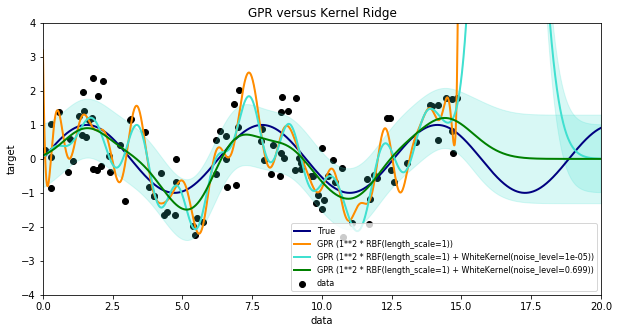

In [44]:

import time

import numpy as np

import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel,RBF

rng = np.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

gp_rbf = ConstantKernel(1.0, constant_value_bounds="fixed")* RBF(1.0, length_scale_bounds="fixed")
gp_rbf_white= gp_rbf + WhiteKernel(noise_level=1e-5, noise_level_bounds="fixed")
gp_rbf_white_bo= gp_rbf + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10,1e+10))

X_plot = np.linspace(0, 20, 10000)[:, None]

stime = time.time()
gpr_rbf = GaussianProcessRegressor(kernel=gp_rbf)
gpr_rbf.fit(X, y)
y_gpr_rbf,y_std_rbf = gpr_rbf.predict(X_plot, return_std=True)
print("Time for GP RBF : %.3f" % (time.time() - stime))

stime = time.time()
gpr_white_bo = GaussianProcessRegressor(kernel=gp_rbf_white_bo)
gpr_white_bo.fit(X, y)
y_gpr_white_bo,y_std_white_bo = gpr_white_bo.predict(X_plot, return_std=True)
print("Time for GP RBF White : %.3f" % (time.time() - stime))

stime = time.time()
gpr_white = GaussianProcessRegressor(kernel=gp_rbf_white)
gpr_white.fit(X, y)
y_gpr_white,y_std_white = gpr_white.predict(X_plot, return_std=True)
print("Time for GP RBF White consider noise_level_bounds : %.3f" % (time.time() - stime))


# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')

plt.plot(X_plot, y_gpr_rbf, color='darkorange', lw=lw,
         label='GPR (%s)' % gpr_rbf.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr_rbf - y_std_rbf, y_gpr_rbf + y_std_rbf, color='darkorange',
                 alpha=0.2)
plt.plot(X_plot, y_gpr_white, color='turquoise', lw=lw,
         label='GPR (%s)' % gpr_white.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr_white - y_std_white, y_gpr_white + y_std_white, color='turquoise',
                 alpha=0.2)

plt.plot(X_plot, y_gpr_white_bo, color='g', lw=lw,
         label='GPR (%s)' % gpr_white_bo.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr_white_bo - y_std_white_bo, y_gpr_white_bo + y_std_white_bo, color='turquoise',
                 alpha=0.2)

plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.title('GPR versus Kernel Ridge')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()

In [20]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init,0.2)



In [43]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern,RBF,WhiteKernel
from time import time

X, y = load_digits(10, True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
kernel_white = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) \
+ WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

m52 = Matern(length_scale=1.0, nu=2.5)
constant=ConstantKernel(1.0, constant_value_bounds="fixed") \
                          * RBF(1.0, length_scale_bounds="fixed")
gpr = GaussianProcessRegressor()

gpr_white = GaussianProcessRegressor(kernel=constant,noise="gaussian")
gpr_Matern = GaussianProcessRegressor(kernel=m52)

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),  
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
     optimizer_kwargs={'base_estimator': gpr,
                        "acq_func": "EI"},
    n_iter=20,
    cv=5
)
start = time()
opt.fit(X_train, y_train)
cost = time()-start
print(f'GP took time {round(cost,2)}s')#

opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),  
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
     optimizer_kwargs={'base_estimator': gpr_white,
                        "acq_func": "EI"},
    n_iter=20,
    cv=5
)
start = time()
opt.fit(X_train, y_train)
cost = time()-start
print(f'GP white took time {round(cost,2)}s')#

opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),  
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
     optimizer_kwargs={'base_estimator': gpr_Matern,
                        "acq_func": "EI"},
    n_iter=20,
    cv=5
)
start = time()
opt.fit(X_train, y_train)
cost = time()-start
print(f'GP Matern took time {round(cost,2)}s')#

GP took time 9.98s
GP white took time 13.92s
GP Matern took time 8.75s


In [46]:
from scipy.stats import randint
from scipy.stats import uniform
print(uniform(0.01, 1.0))
